In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
#some utility function(s)

def show_eval_metrics(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=y['Class'].unique(), yticklabels=y['Class'].unique())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Load the dataset and prepare the data splits

In [3]:
#load the gene-expression matrix
data_path = './data/TCGA-PANCAN-HiSeq-801x20531'

df_X = pd.read_csv(f'{data_path}/data.csv', delimiter=',')
print(df_X.shape)

df_y = pd.read_csv(f'{data_path}/labels.csv', delimiter=',')
print(df_y.shape)

(801, 20532)
(801, 2)


In [4]:
#Let's print a first few samples and their expressions for each gene
df_X.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [5]:
#and, to which classes these samples belong?
df_y.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


In [6]:
X = df_X.iloc[:,1:]
y = df_y.iloc[:,1:]

In [7]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

We will start with a single RF model, first (no hyperparameter tuning; defaulted to scikit-learn)

Accuracy: 0.8757763975155279
              precision    recall  f1-score   support

        BRCA       0.83      0.98      0.90        60
        COAD       0.72      0.81      0.76        16
        KIRC       0.93      0.87      0.90        30
        LUAD       0.95      0.64      0.77        28
        PRAD       1.00      0.93      0.96        27

    accuracy                           0.88       161
   macro avg       0.89      0.85      0.86       161
weighted avg       0.89      0.88      0.87       161



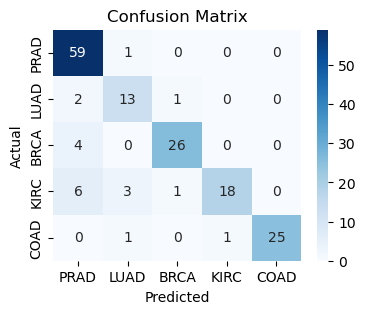

In [8]:
n_trees = 2
rf_model = RandomForestClassifier(n_estimators=n_trees, random_state=42)

# Fit to the training set
rf_model.fit(X_train, y_train.values.ravel())

# Predict on the test set
y_pred = rf_model.predict(X_test)

show_eval_metrics(y_test, y_pred)

**Questions**
1. Play with the `n_trees` parameters to see what effects it has on the training and testing performance.
2. What can you say about this model when `n_trees=1`?

Note: In "good" machine learning, you MUST never use the test set to determine the best parameters. But, here we are just trying to observe some effects on the test set performance and nothing more.

We will now construct a hyperparameter tuned RF model

In [9]:
# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

In [10]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [11]:
# Use GridSearchCV or RandomizedSearchCV

# For GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# For RandomizedSearchCV (faster for large grids)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

In [12]:
# Fit the model
random_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 15, 20, 25,
                                                      30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50]},
                   random_state=42, verbose=2)

In [13]:
# Get the best model
best_rf = random_search.best_estimator_

In [14]:
# Predict on the test set
y_pred = best_rf.predict(X_test)

In [15]:
# Let's see the best parameters
print("Best parameters:\n")
print(random_search.best_params_)

Best parameters:

{'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


Accuracy: 0.9875776397515528
              precision    recall  f1-score   support

        BRCA       0.97      1.00      0.98        60
        COAD       1.00      1.00      1.00        16
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      0.93      0.96        28
        PRAD       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



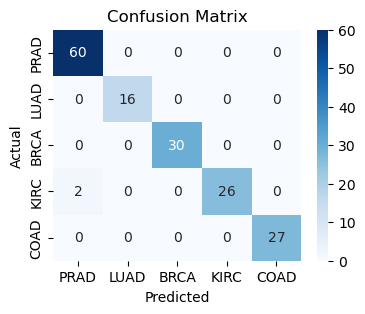

In [16]:
# Show evaluation metrics
show_eval_metrics(y_test, y_pred)

**Further Reading**

Scikit-learn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) would be a good start towards implementational aspects.